# This notebook contains code for creating and evaluating the baseline model and subsequent models

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sqlalchemy import create_engine
import sqlite3 as sql
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score, make_scorer, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

import imblearn.over_sampling

In [2]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [3]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in dataset for modeling

In [18]:
conn = sql.connect('classification.db')
df_X = pd.read_sql('SELECT * FROM Subjects_Force_Incidents', conn)

In [19]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 55 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   subject_id                                             13230 non-null  int64  
 1   tri_incident_number                                    13230 non-null  int64  
 2   forcetype_Firearm                                      13230 non-null  int64  
 3   forcetype_Impact Weapon                                13230 non-null  int64  
 4   forcetype_OC Spray                                     13230 non-null  int64  
 5   forcetype_Physical Force                               13230 non-null  int64  
 6   forcetype_Police Canine                                13230 non-null  int64  
 7   forcetype_Restraining Mesh Blanket                     13230 non-null  int64  
 8   basis_encounter_AMBUSH OF MEMBER              

# Model Preparation

First, since I'm using logistic regression and I have numeric variables on different scales, I need to standardize them so they're on the same scale.

In [6]:
# scale numeric features
cols_to_scale = ['num_members','num_subjects','subject_age','incidents_per_season']
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

Next, I split my dataset twice: first, into training and test sets and then, from the training set into training and validation sets.

In [7]:
# split the data into train/validate/test sets on randomly selected groups of non-NYPD subjects

# all data -> train / test
np.random.seed(42)
total_subjects = df_X['subject_id'].unique() 
test_subjects = np.random.choice(total_subjects, size=int(total_subjects.shape[0] * .20))

df_X_tr_val, df_X_te = df_X[~df_X['subject_id'].isin(test_subjects)], df_X[df_X['subject_id'].isin(test_subjects)]


total_train_val_subjects = df_X_tr_val['subject_id'].unique() 
val_subjects = np.random.choice(total_train_val_subjects, size=int(total_train_val_subjects.shape[0] * .25))

df_X_tr, df_X_val = df_X_tr_val[~df_X_tr_val['subject_id']
                                .isin(val_subjects)], df_X_tr_val[df_X_tr_val['subject_id']
                                                                              .isin(val_subjects)]

y_tr, y_val, y_te = df_X_tr['subject_injured'], df_X_val['subject_injured'], df_X_te['subject_injured']
X_tr, X_val, X_te = df_X_tr.drop(['subject_id','tri_incident_number','subject_injured'],axis=1), \
             df_X_val.drop(['subject_id','tri_incident_number','subject_injured'],axis=1), \
             df_X_te.drop(['subject_id','tri_incident_number','subject_injured'],axis=1)

Now that I have my dataset ready, I can create a helper function that will allow me to cross-validate, create an ROC curve to plot it calculate the ROC AUC score, and create confusion matrices.

In [8]:
def cross_validate_roc_cm(model, X_train, y_train, X_validate, y_validate):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring_metrics)

    # Report results
    
    print(f"recall scores: {(cv_results['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results['test_rec'])):.3f}")
    print("")
    print(f"f2 scores: {(cv_results['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results['test_f2_score'])):.3f}")
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_validate, model.predict_proba(X_validate)[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')

    # axis labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for serious subject injury problem')
    plt.legend()
    plt.show()
    print("ROC AUC score = ", roc_auc_score(y_validate, model.predict_proba(X_validate)[:,1]))
    
    # create and plot confusion matrix with training data
    con_mat = confusion_matrix(y_train, model.predict(X_train))
    plt.figure(dpi=100)
    sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Training data')
    plt.show()
    
    # create and plot confusion matrix with validation data
    con_mat = confusion_matrix(y_validate, model.predict(X_validate))
    plt.figure(dpi=100)
    sns.heatmap(con_mat, cmap=plt.cm.Blues, annot=True, square=True)

    plt.xlabel('Predicted serious injury')
    plt.ylabel('Actual serious injury')
    plt.title('Confusion Matrix - Validation data')
    plt.show()

# Baselining Model

I'm ready to create my baseline model!

In [9]:
lr_base = LogisticRegression(solver='liblinear',max_iter=10000)
lr_base.fit(X_tr,y_tr)

LogisticRegression(max_iter=10000, solver='liblinear')

recall scores: [0.06451613 0.04761905 0.08333333 0.08333333 0.03125   ]

mean recall: 0.062

f2 scores: [0.07874016 0.05882353 0.10135135 0.10135135 0.03846154]

mean f2 score: 0.076


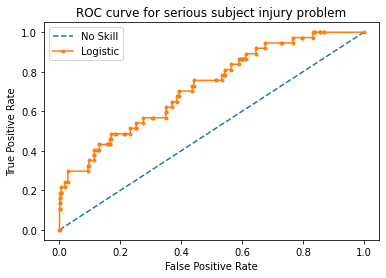

ROC AUC score =  0.7237052181803564


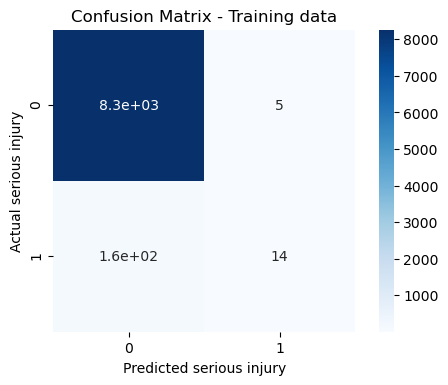

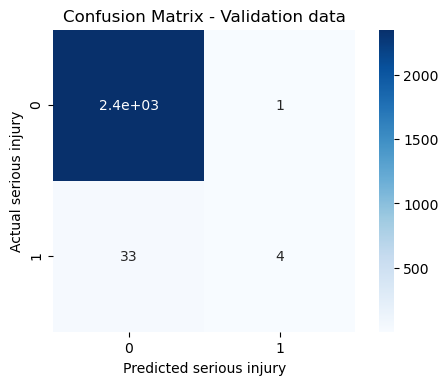

In [10]:
cross_validate_roc_cm(lr_base,X_tr,y_tr,X_val,y_val)

The results of the base model indicate that there's a lot of room for improvement with the F2 and recall scores. Looking at the matrices, we can see that with both training and validation data, we have many more false negatives than false positives, which is not ideal for our business problem (false positives for us are better than false negatives).

# Second Model

Because my dataset is very imbalanced (approximately 98% are in the negative class and 2% are in the positive class), I'm choosing to deal with this first by oversampling and hopefully improve my model.

Since I'm not sure what the best ratio is to use, I'm going to try out several and plot the scores versus the ratio value to pick the optimal one.

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (8319) in class 1 will be larger than the number of samples in the majority class (class #0 -> 8267)
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (8496) in class 1 will be larger than the number of samples in the majority class (class #0 -> 8267)
  warnings.warn(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:299: UserWarning: After over-sampling, the number of samples (8673) in class 1 will be larger than the number of samples in the majority class (class #0 -> 8267)
  warnings.warn(


Logistic Regression Model best F2 score 0.242 at ratio = 12 to 1


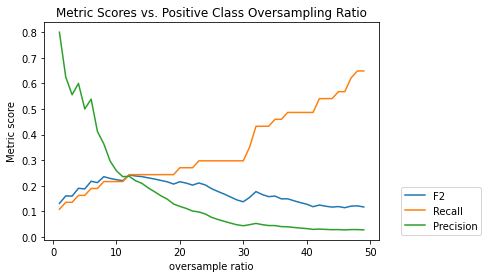

In [11]:
ratio_ps = range(1,50)

f2_scores, rec_scores, prec_scores = [], [], []

for curr_ratio in ratio_ps:

    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos * int(curr_ratio), 0 : n_neg} 

    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)
    
    lr = LogisticRegression(solver='liblinear',max_iter=10000)
    lr.fit(X_tr_rs,y_tr_rs)
    
    f2_scores.append(fbeta_score(y_val, lr.predict(X_val), beta=2))    
    rec_scores.append(recall_score(y_val, lr.predict(X_val)))
    prec_scores.append(precision_score(y_val, lr.predict(X_val)))
    
plt.plot(ratio_ps, f2_scores)
plt.plot(ratio_ps, rec_scores)
plt.plot(ratio_ps, prec_scores)

plt.title('Metric Scores vs. Positive Class Oversampling Ratio')
plt.legend(['F2','Recall','Precision'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('oversample ratio')
plt.ylabel('Metric score')

best_f2_score = np.max(f2_scores) 
best_ratio = ratio_ps[np.argmax(f2_scores)]

print('Logistic Regression Model best F2 score %.3f at ratio = %.0f to 1' 
      % (best_f2_score, best_ratio))

Now that I know the optimal F2 score is with a ratio of 12 to 1 for positives to negatives, I'm going to oversample using this ratio for my second model.

In [12]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 12, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

In [13]:
lr_2 = LogisticRegression(solver='liblinear',max_iter=10000)
lr_2.fit(X_tr_rs,y_tr_rs)

LogisticRegression(max_iter=10000, solver='liblinear')

recall scores: [0.20487805 0.17866005 0.16894977 0.15401786 0.14588235]

mean recall: 0.170

f2 scores: [0.24041214 0.21003501 0.20043337 0.18321827 0.17435321]

mean f2 score: 0.202


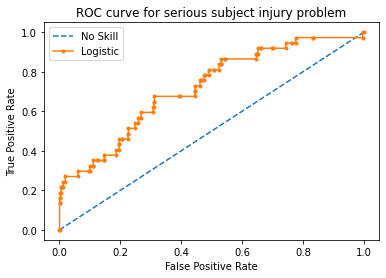

ROC AUC score =  0.7191681694444125


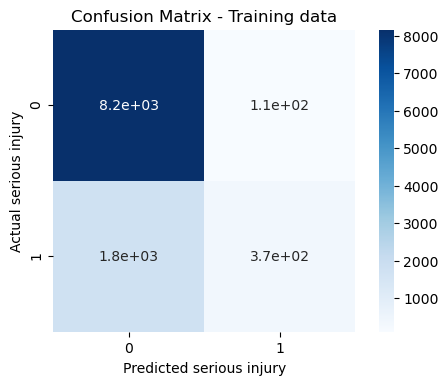

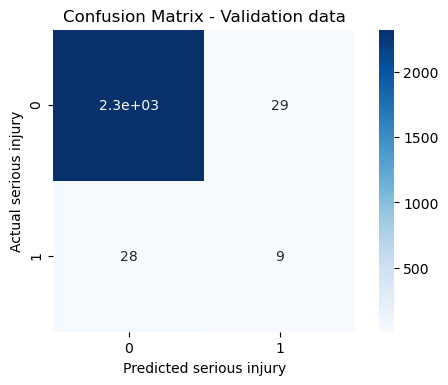

In [14]:
cross_validate_roc_cm(lr_2, X_tr_rs,y_tr_rs, X_val, y_val)

There's some improvement here when we look at confusion matrix with the validation data -> it went from 4/(33+4) = ~10% with the base model to 9/(9+28) = ~ 24%.

Next, I will try further addressing the class imbalance issue by experimenting with adjusting class weights. Since I'm not sure what the optimal class weight ratio is, I'm going to experiment with different values.

# Third model

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

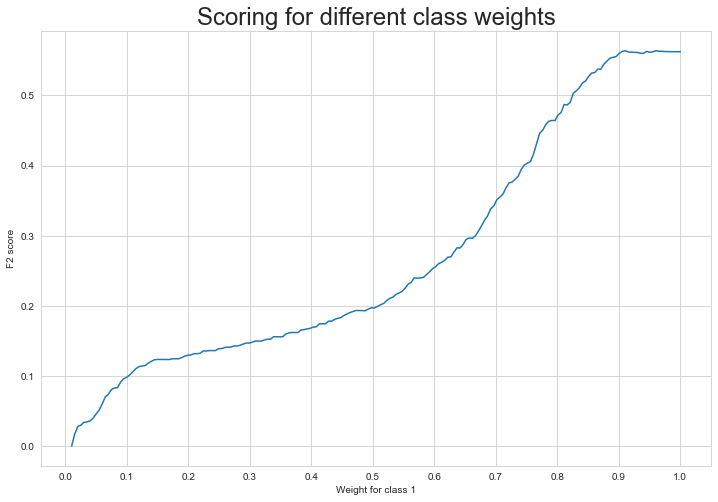

In [15]:
# I got help with writing this code from this webpage: https://developpaper.com/using-class-weight-to-improve-class-imbalance/

lr_weight = LogisticRegression(solver='liblinear')

#Define scoring metrics

f2_score = make_scorer(fbeta_score, beta=2)

#Set the range of class weights
weights = np.linspace(0.0,0.99,200)

#Create dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

##Fitting training data with 5 times grid search method
gridsearch = GridSearchCV(estimator= lr_weight, 
                          param_grid= param_grid,
                          n_jobs=-1, 
                          scoring=f2_score, 
                          refit=False).fit(X_tr_rs, y_tr_rs)

#Draw fractions with different weight values
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weight_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weight_data['weight'], weight_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F2 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

From the above graph, it looks like about .9 is the optimal class weight for class 1. Let's confirm with some more code:

In [16]:
weight_data['score'].argmax()
weight_data.iloc[32,:]

score     0.517736
weight    0.840804
Name: 32, dtype: float64

The optimal weight for class 1 to be 0.840804, meaning the class weight for class 0 will be 1-0.840804=0.159196.

Next, we'll apply these class weights to our third model and see how it performs.

In [17]:
lr_3 = LogisticRegression(class_weight={1 : 0.840804, 0 : 0.159196},solver='liblinear',max_iter=10000)
lr_3.fit(X_tr_rs,y_tr_rs)

LogisticRegression(class_weight={0: 0.159196, 1: 0.840804}, max_iter=10000,
                   solver='liblinear')

recall scores: [0.77317073 0.79900744 0.77853881 0.80133929 0.78823529]

mean recall: 0.788

f2 scores: [0.56769341 0.57788945 0.58752584 0.60971467 0.58751315]

mean f2 score: 0.586


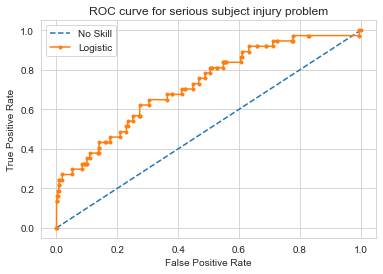

ROC AUC score =  0.7246815451235342


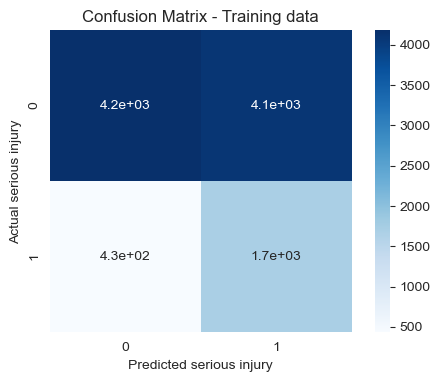

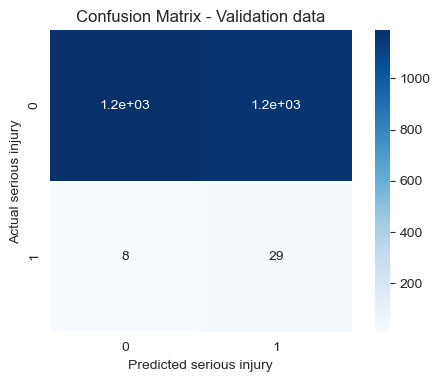

In [18]:
cross_validate_roc_cm(lr_3,X_tr_rs,y_tr_rs,X_val,y_val)

Here we can see that adjusting the class weights had a large impact on the recall scores for both the training and validation sets (at the same time, precision went way down because we're classifying many more true negatives as false positives). The recall score for validation data went from (9/28+9) = ~24% with model 2 to 29/(29+8) = ~78% with model 3.

Next, I'll use L1 regularization (aka Lasso) to identify redundant features that can be removed.

# Fourth model

In [19]:
lr_4 = LogisticRegression(penalty='l1',class_weight={1 : 0.840804, 0 : 0.159196},solver='liblinear',max_iter=10000)
lr_4.fit(X_tr_rs,y_tr_rs)

LogisticRegression(class_weight={0: 0.159196, 1: 0.840804}, max_iter=10000,
                   penalty='l1', solver='liblinear')

recall scores: [0.77317073 0.79404467 0.77625571 0.79910714 0.78588235]

mean recall: 0.786

f2 scores: [0.56647605 0.57574667 0.5862069  0.60677966 0.58844257]

mean f2 score: 0.585


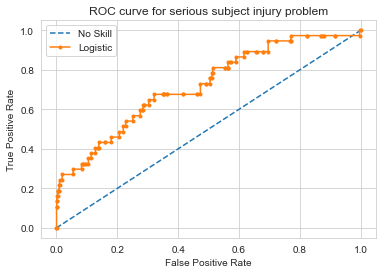

ROC AUC score =  0.7205120547661984


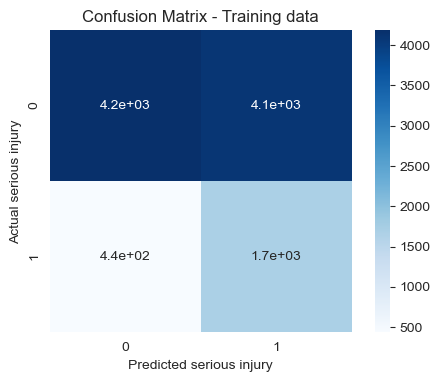

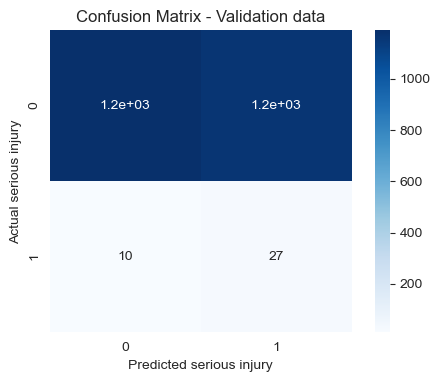

In [20]:
cross_validate_roc_cm(lr_4,X_tr_rs,y_tr_rs,X_val,y_val)

In [21]:
lr_4.coef_

array([[ 3.64802083,  0.93449149, -1.33829534, -0.51712528,  0.        ,
         0.        ,  1.97328111,  0.        ,  1.09503627,  0.        ,
         1.12182015,  0.        ,  0.        ,  2.55006159,  0.11339147,
        -1.52915417,  0.61856486, -0.8104988 ,  0.        ,  0.86178905,
         2.9518519 , -1.52832281,  0.89995981,  1.15580827,  0.25022757,
         1.49572151, -0.80084352,  0.        ,  0.62477627,  0.        ,
         0.06433854, -0.02493455, -0.71624949, -0.17365432,  0.09302544,
        -0.29187856,  0.19031497, -0.44171922, -0.37481802,  0.        ,
         0.06206865,  0.1004694 ,  0.20747215,  0.        ,  0.        ,
         0.        ,  0.07474652,  0.21230279,  0.15164179,  0.        ,
         0.2382434 , -0.06117985]])

In [22]:
print(np.round(lr_4.coef_[0],0))

[ 4.  1. -1. -1.  0.  0.  2.  0.  1.  0.  1.  0.  0.  3.  0. -2.  1. -1.
  0.  1.  3. -2.  1.  1.  0.  1. -1.  0.  1.  0.  0. -0. -1. -0.  0. -0.
  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.]


The coefficents rounded to zero are the redundant features.

In [23]:
coef = np.round(lr_4.coef_[0],0)
useful_features = pd.Series(X_tr_rs.columns)[list(coef!=0)]
print(f"Number of 'useful' features (i.e., those that don't have coefficients of 0): {(len(useful_features))}")
print(f"Number of original features: {(len(lr_4.coef_[0]))}")

Number of 'useful' features (i.e., those that don't have coefficients of 0): 20
Number of original features: 52


Next, I'll update the feature sets for train, val, and test sets so they only include the smaller subset of 20 features for further modeling.

In [24]:
X_tr_rs = X_tr_rs[useful_features]
X_val =  X_val[useful_features]
X_te = X_te[useful_features]

# Fifth model

Now, that I have fewer features, I'll fit a new model with them and do cross-validation. I'm also going to try balancing the class weight, since using the ratio of class weights in the fourth model made the precision scores drastically decrease due to the much larger number of false positives for both the training and validation sets.

In [49]:
lr_5 = LogisticRegression(class_weight='balanced',solver='liblinear',max_iter=10000)
lr_5.fit(X_tr_rs,y_tr_rs)

LogisticRegression(class_weight='balanced', max_iter=10000, solver='liblinear')

recall scores: [0.79512195 0.74689826 0.69406393 0.703125   0.69176471]

mean recall: 0.726

f2 scores: [0.57924662 0.57662835 0.55494706 0.56634304 0.54973822]

mean f2 score: 0.565


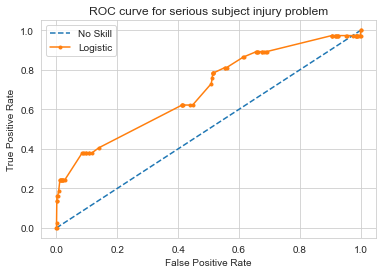

ROC AUC score =  0.6941569704000643


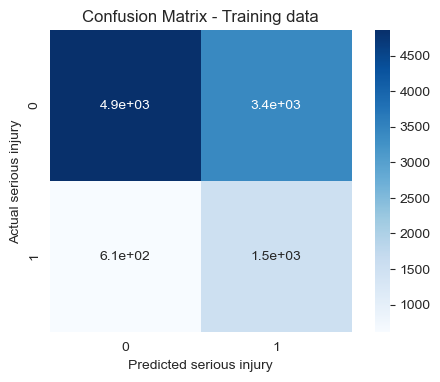

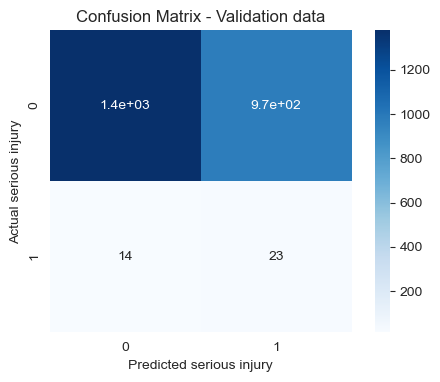

In [50]:
cross_validate_roc_cm(lr_5,X_tr_rs,y_tr_rs,X_val,y_val)

Looking at these the training and validation data set confusion matrices for model 5, we can see that the recall score for the validation data declined somewhat (from 27/(27+10) = ~73% for model 4 to ~23/(23+14) = ~62%).

Meanwhile, precision is about the same for the validation set (~2%). Given this, I will run the model again using the weights ratio from the GridSearchCV, since I rather have better recall score if it means I'll have the same precision score. I will try 5 for the C value.

# Sixth Model

In [53]:
lr_6 = LogisticRegression(class_weight={1 : 0.840804, 0 : 0.159196},solver='liblinear',max_iter=10000)
lr_6.fit(X_tr_rs,y_tr_rs)

LogisticRegression(class_weight={0: 0.159196, 1: 0.840804}, max_iter=10000,
                   solver='liblinear')

recall scores: [0.81707317 0.84367246 0.7716895  0.81473214 0.79058824]

mean recall: 0.808

f2 scores: [0.57382665 0.59027778 0.57482993 0.60853618 0.58131488]

mean f2 score: 0.586


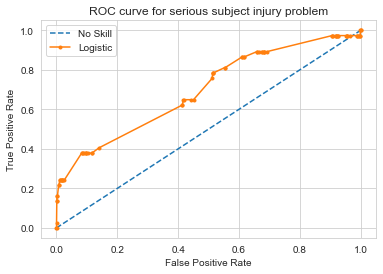

ROC AUC score =  0.6966265032563376


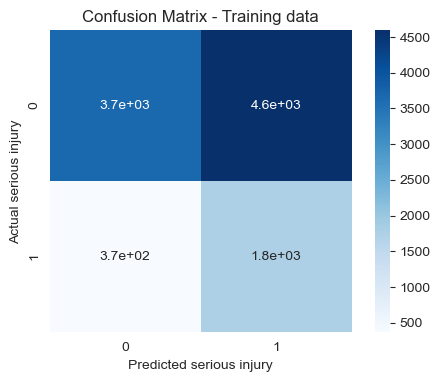

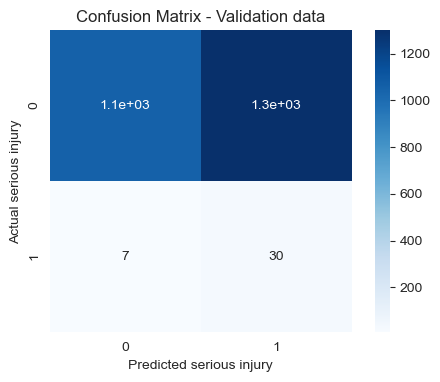

In [54]:
cross_validate_roc_cm(lr_6,X_tr_rs,y_tr_rs,X_val,y_val)

Next, I'll look at the coefficients of my final model 5 to interpret their meanings

In [55]:
lr_6_feature_coeffs = pd.DataFrame({'features': X_tr_rs.columns,
                   'coefficients': lr_6.coef_.flatten()}).\
                    sort_values('coefficients', ascending = False)
lr_6_feature_coeffs

,features,coefficients
0,forcetype_Firearm,3.152736
12,basis_encounter_SEARCH WARRANT,2.529622
7,basis_encounter_IN CUSTODY INJURY,2.380342
4,basis_encounter_AMBUSH OF MEMBER,1.541143
16,force_against_mos_Cutting Instrument,1.303075
6,basis_encounter_DETECTIVE INVESTIGATION,1.156983
15,"basis_encounter_WANTED SUSPECT (E.G. WARRANT, ...",1.099253
5,basis_encounter_CRIME/VIOLATION IN PROGRESS,1.070925
1,forcetype_Impact Weapon,0.952569
14,basis_encounter_VTL INFRACTION,0.927699


All of the coefficients come from 4 features in the original dataset, so I will add a column to the feature coefficients dataframe that assigns them to a group. This will help with plotting.

In [57]:
forcetype = 'forcetype'
basis = 'basis_encounter'
force_against = 'force_against_mos'
patrol_borough = 'patrol_borough'

def feature_group(x):
    if forcetype in x:
        return 1
    elif basis in x:
        return 2
    elif force_against in x:
        return 3
    else:
        return 4

lr_6_feature_coeffs['group'] = lr_6_feature_coeffs['features'].apply(feature_group)

# save final model features as csv
lr_6_feature_coeffs.to_csv('final_model_coeffs.csv', index=False)

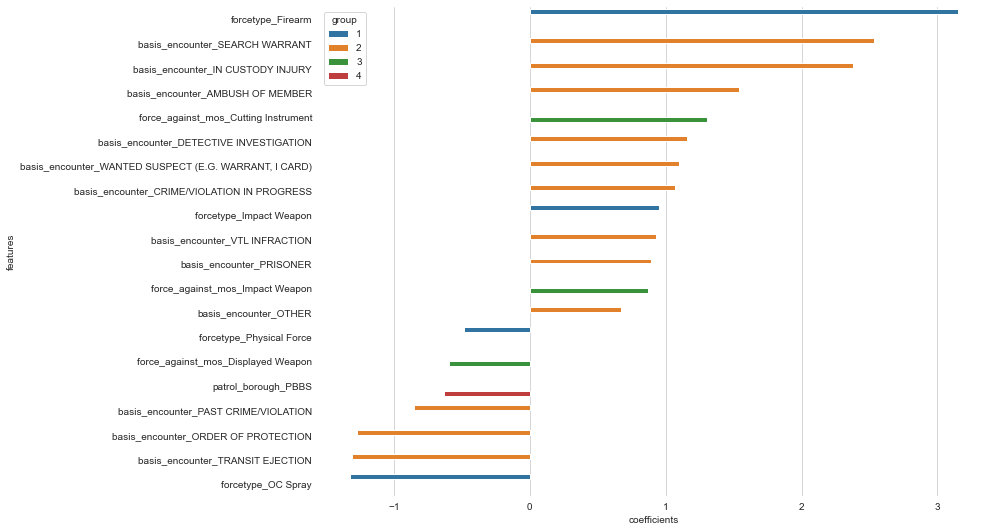

In [58]:
# plot the features and their coefficients
f, ax = plt.subplots(figsize=(12, 9))
sns.set_color_codes("pastel")
sns.barplot(x="coefficients", y="features", data=lr_6_feature_coeffs,hue='group')
sns.despine(left=True, bottom=True)
#plt.savefig('mvp.png',bbox_inches='tight')

The categories for each feature group not included:
- forcetype (7 total) -> Electrical Weapon (reference category); Police Canine; Restraining Mesh Blanket
- force_against_mos (6 total) -> No Force (reference category); Firearm; Displayed Weapon; Physical Force
- basis_encounter (19 total) -> SUSPICIOUS ACTIVITY (reference category); PAST CRIME VIOLATION; HOME VISIT; ANIMAL CONDITION; HOSTAGE BARRICADED; PERSON IN CRISIS; CROWD CONTROL; NON-CRIME CALLS FOR SERVICE
- patrol_borough (8 total) -> PBBN (reference category), PBBX, PBMN, PBQS, PBQN, PBMS, PBSI

To convert the coefficients in log-odds to probabilities, use the following formula:
probability = 1 / (1 + exp(-x))

We can make predictions from these coefficients. I got help with how to do this using <a href="https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/">this article</a>.

Let's consider the scenario of non-NYPD subject who...
- was involved in an encounter with 1+ NYPD members of service on the basis of a vehicle traffic law infraction in the patrol borough of Brooklyn South
- used no force against 1+ NYPD members of service
- and experienced force from 1+ NYPD members of service in the form of an impact weapon (impact weapon includes straight baton, expandable baton, or any object (other than a part of the officer’s body) that is used to strike a subject).

If we compute all the effects and add them up we have + 0.9277 (VTL infraction basis for encounter = yes) - 0.6305 (patrol brough Brooklyn South = yes) + 0 (no force against mos = 0) + 0.9526 (impact weapon force experienced = yes) = 1.2498

In [72]:
0.9277-0.6305+0.9526

1.2498

In [76]:
0.9277-0.6305+0.9526+float(lr_6.intercept_)

1.07342736772787

In [77]:
1 /(1 + np.exp(-1.0734))

0.7452429639182669

We then need to add the intercept (which we get by doing lr_6.intercept_), which gives us 1.2498 + - 0.1764 = 1.073. 

Next, we do the logistic transformation to calculate the probability from this log-odds:

probability = 1 / (1 + exp(-x)) = 1 /(1 + exp(-1.0734)) = ~0.75 = ~75%

Thus, given this model, we would expect that a non-NYPD subject who was involved in an encounter with 1+ members of service on the basis of a vehicle traffic law infraction in the patrol borough of Brooklyn South, didn't use any force against a NYPD member of service, and experienced force in the form of an impact weapon to have a 75% probability of suffering a level 2, 3 or 4 injury.

If we redo this, just changing one thing, which is substituting the type of force used from an impact weapon to OC spray (like mace or pepper spray), we would expect the subject to have a __ % probability of suffering a level 2, 3 or 4 injury. 

In [82]:
0.9277-0.6305-1.325849+float(lr_6.intercept_)

-1.20502163227213

In [83]:
1 /(1 + np.exp(1.2050))

0.2305869387712515

Evaluate model with testing data

In [69]:
scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_results_5_te = cross_validate(lr_5, X_te, y_te, cv=kf, scoring=scoring_metrics)

print(f"recall scores: {(cv_results_5_te['test_rec'])}")
print("")
print(f"mean recall score: {(np.mean(cv_results_5_te['test_rec'])):.3f}")
print("")
print(f"F2 score scores: {(cv_results_5_te['test_f2_score'])}")
print("")
print(f"F2 score score: {(np.mean(cv_results_5_te['test_f2_score'])):.3f}")

recall scores: [0.5        0.5625     0.71428571 0.66666667 0.4375    ]

mean recall score: 0.576

F2 score scores: [0.1048951  0.15100671 0.16778523 0.15151515 0.21212121]

F2 score score: 0.157


Text(47.722222222222214, 0.5, 'Actual level 2, 3 or 4 injury')

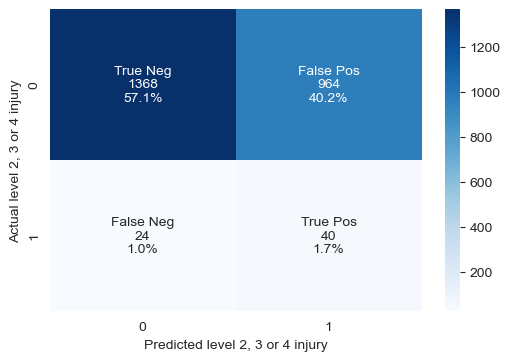

In [68]:
# create and plot confusion matrix with test data
con_mat = confusion_matrix(y_te, lr_5.predict(X_te))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                con_mat.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     con_mat.flatten()/np.sum(con_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(dpi=100)
sns.heatmap(con_mat, annot=labels, fmt="", cmap='Blues')
plt.xlabel('Predicted level 2, 3 or 4 injury')
plt.ylabel('Actual level 2, 3 or 4 injury')